In [1]:
from typing import Dict

import pandas as pd
from IPython.display import Image

import spacy
import neuralcoref
import neo4j

<frozen importlib._bootstrap>:219: RuntimeWarning: spacy.morphology.Morphology size changed, may indicate binary incompatibility. Expected 104 from C header, got 112 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: spacy.vocab.Vocab size changed, may indicate binary incompatibility. Expected 96 from C header, got 112 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: spacy.tokens.span.Span size changed, may indicate binary incompatibility. Expected 72 from C header, got 80 from PyObject


## Neo4j Desktop を起動してプロジェクトに接続

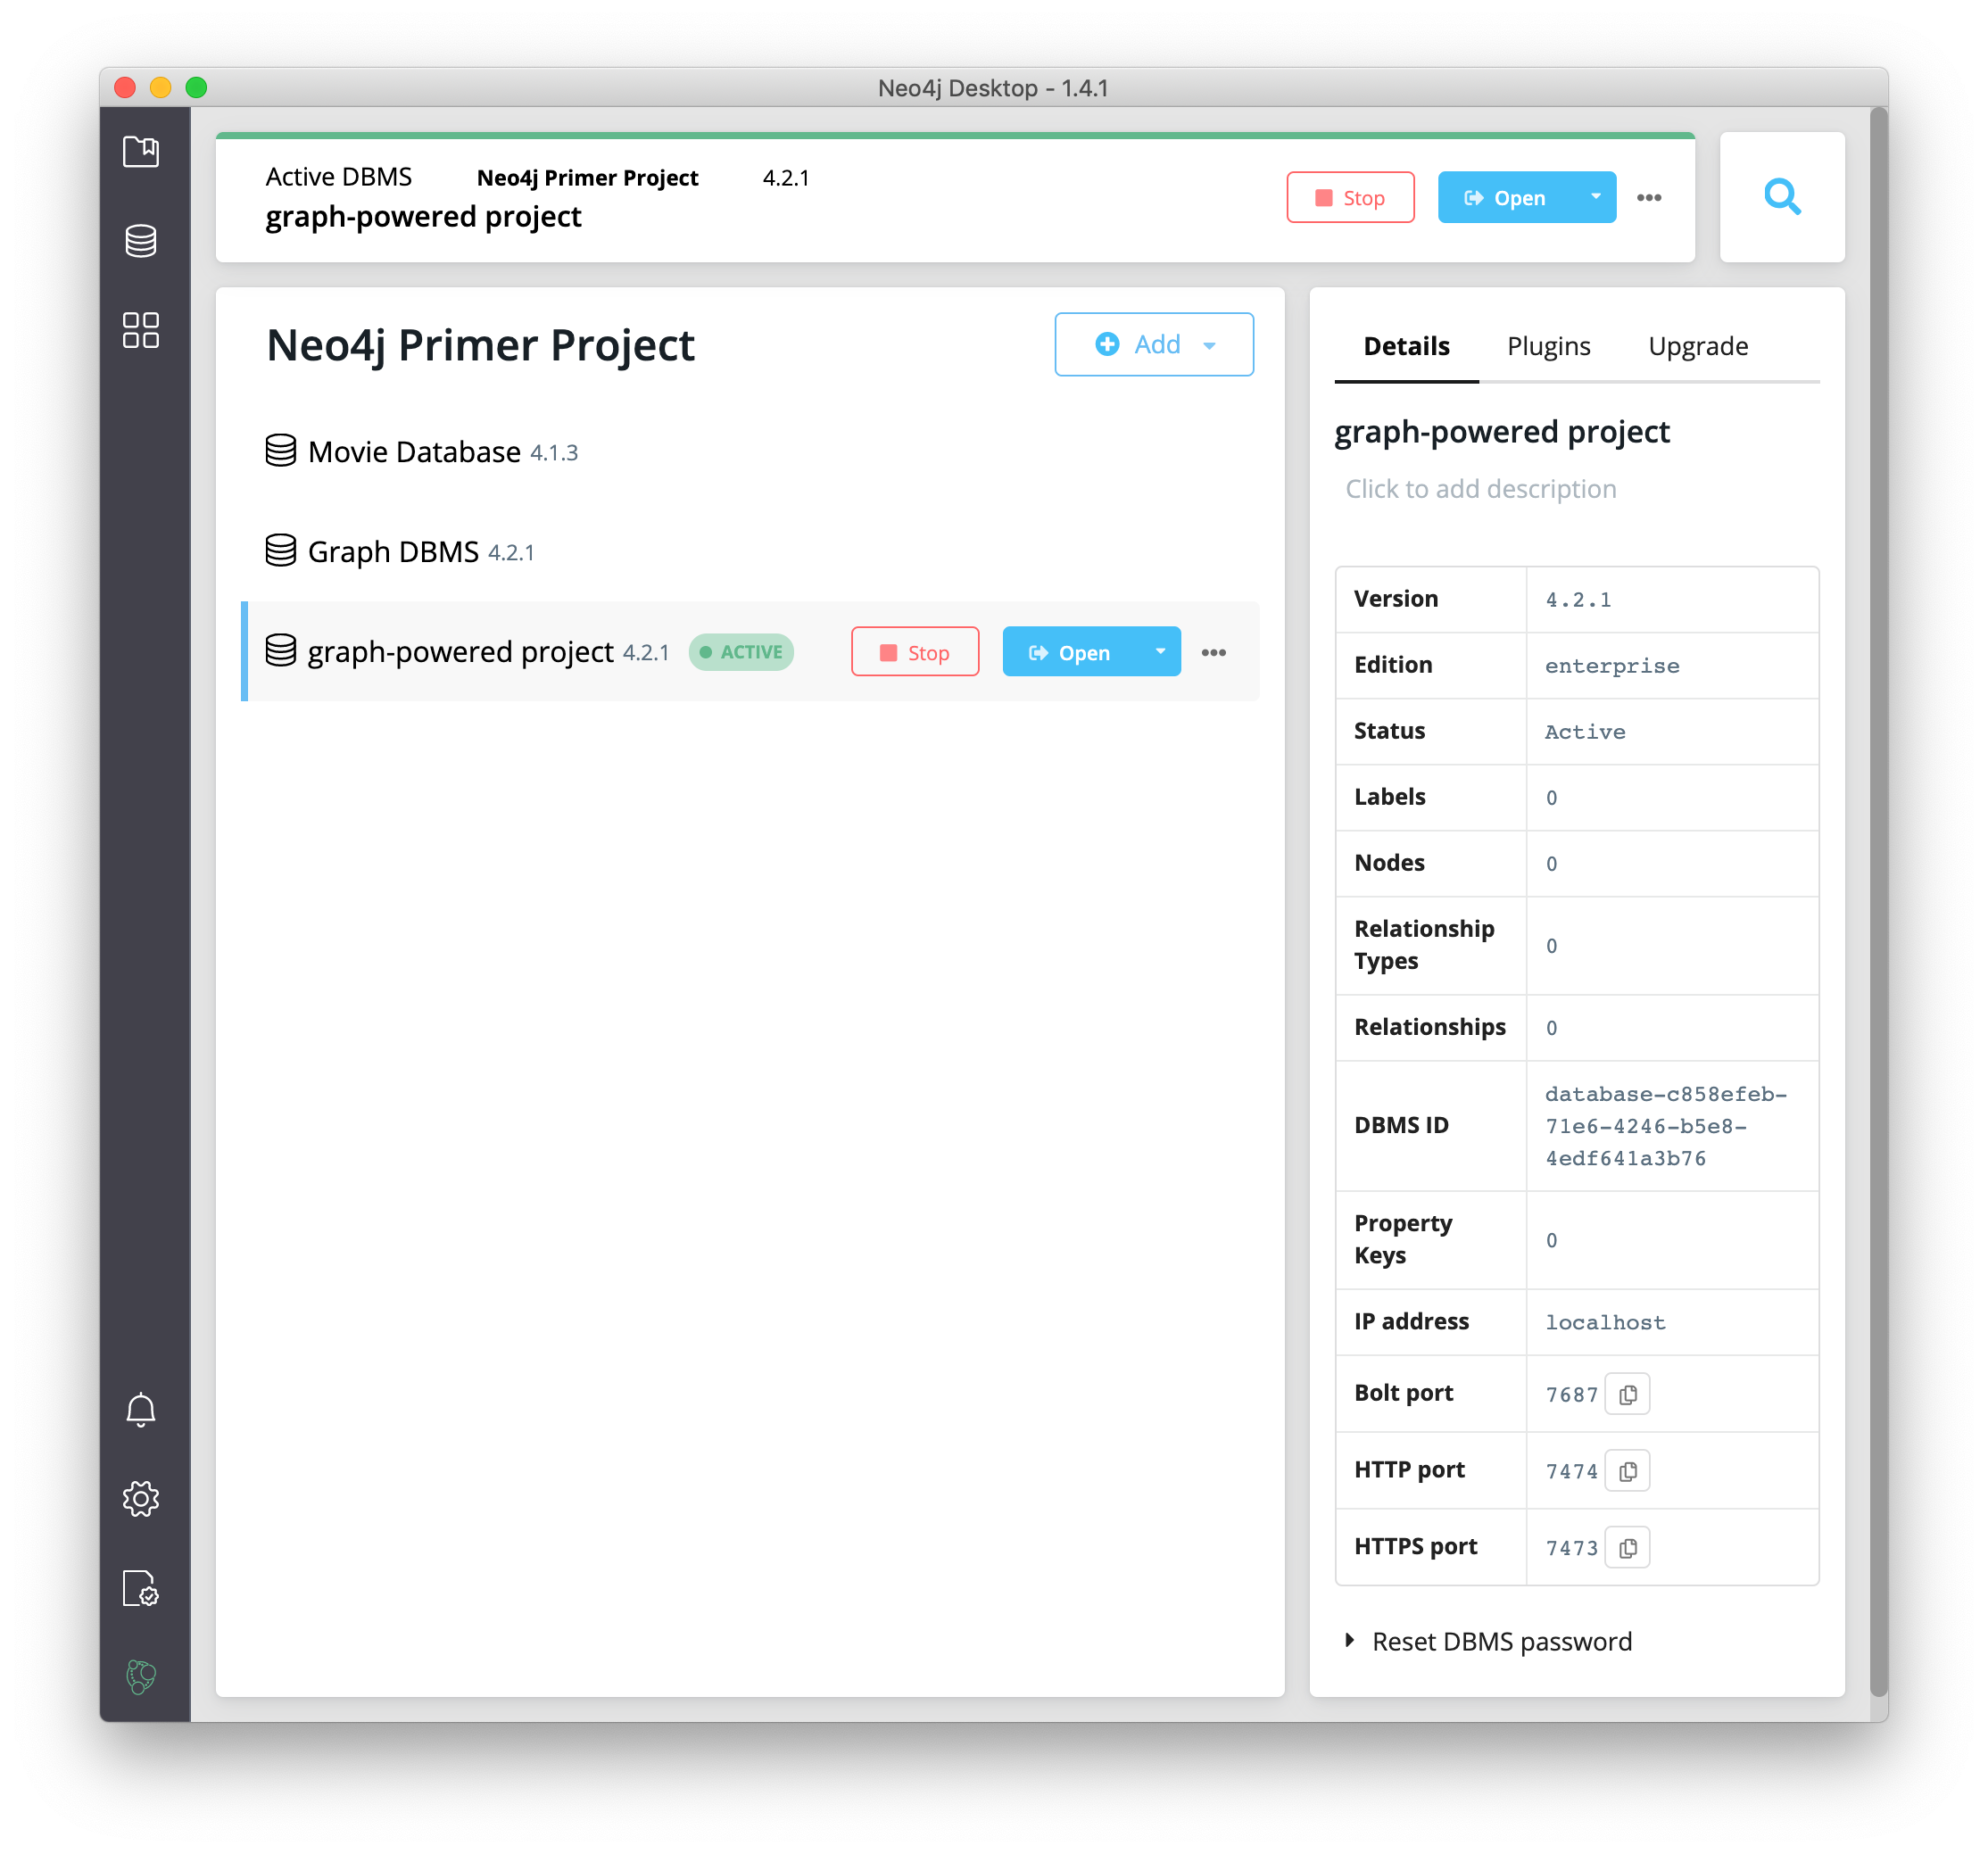

In [2]:
Image("./images/neo4j_desktop.png")

### APOC のインストール

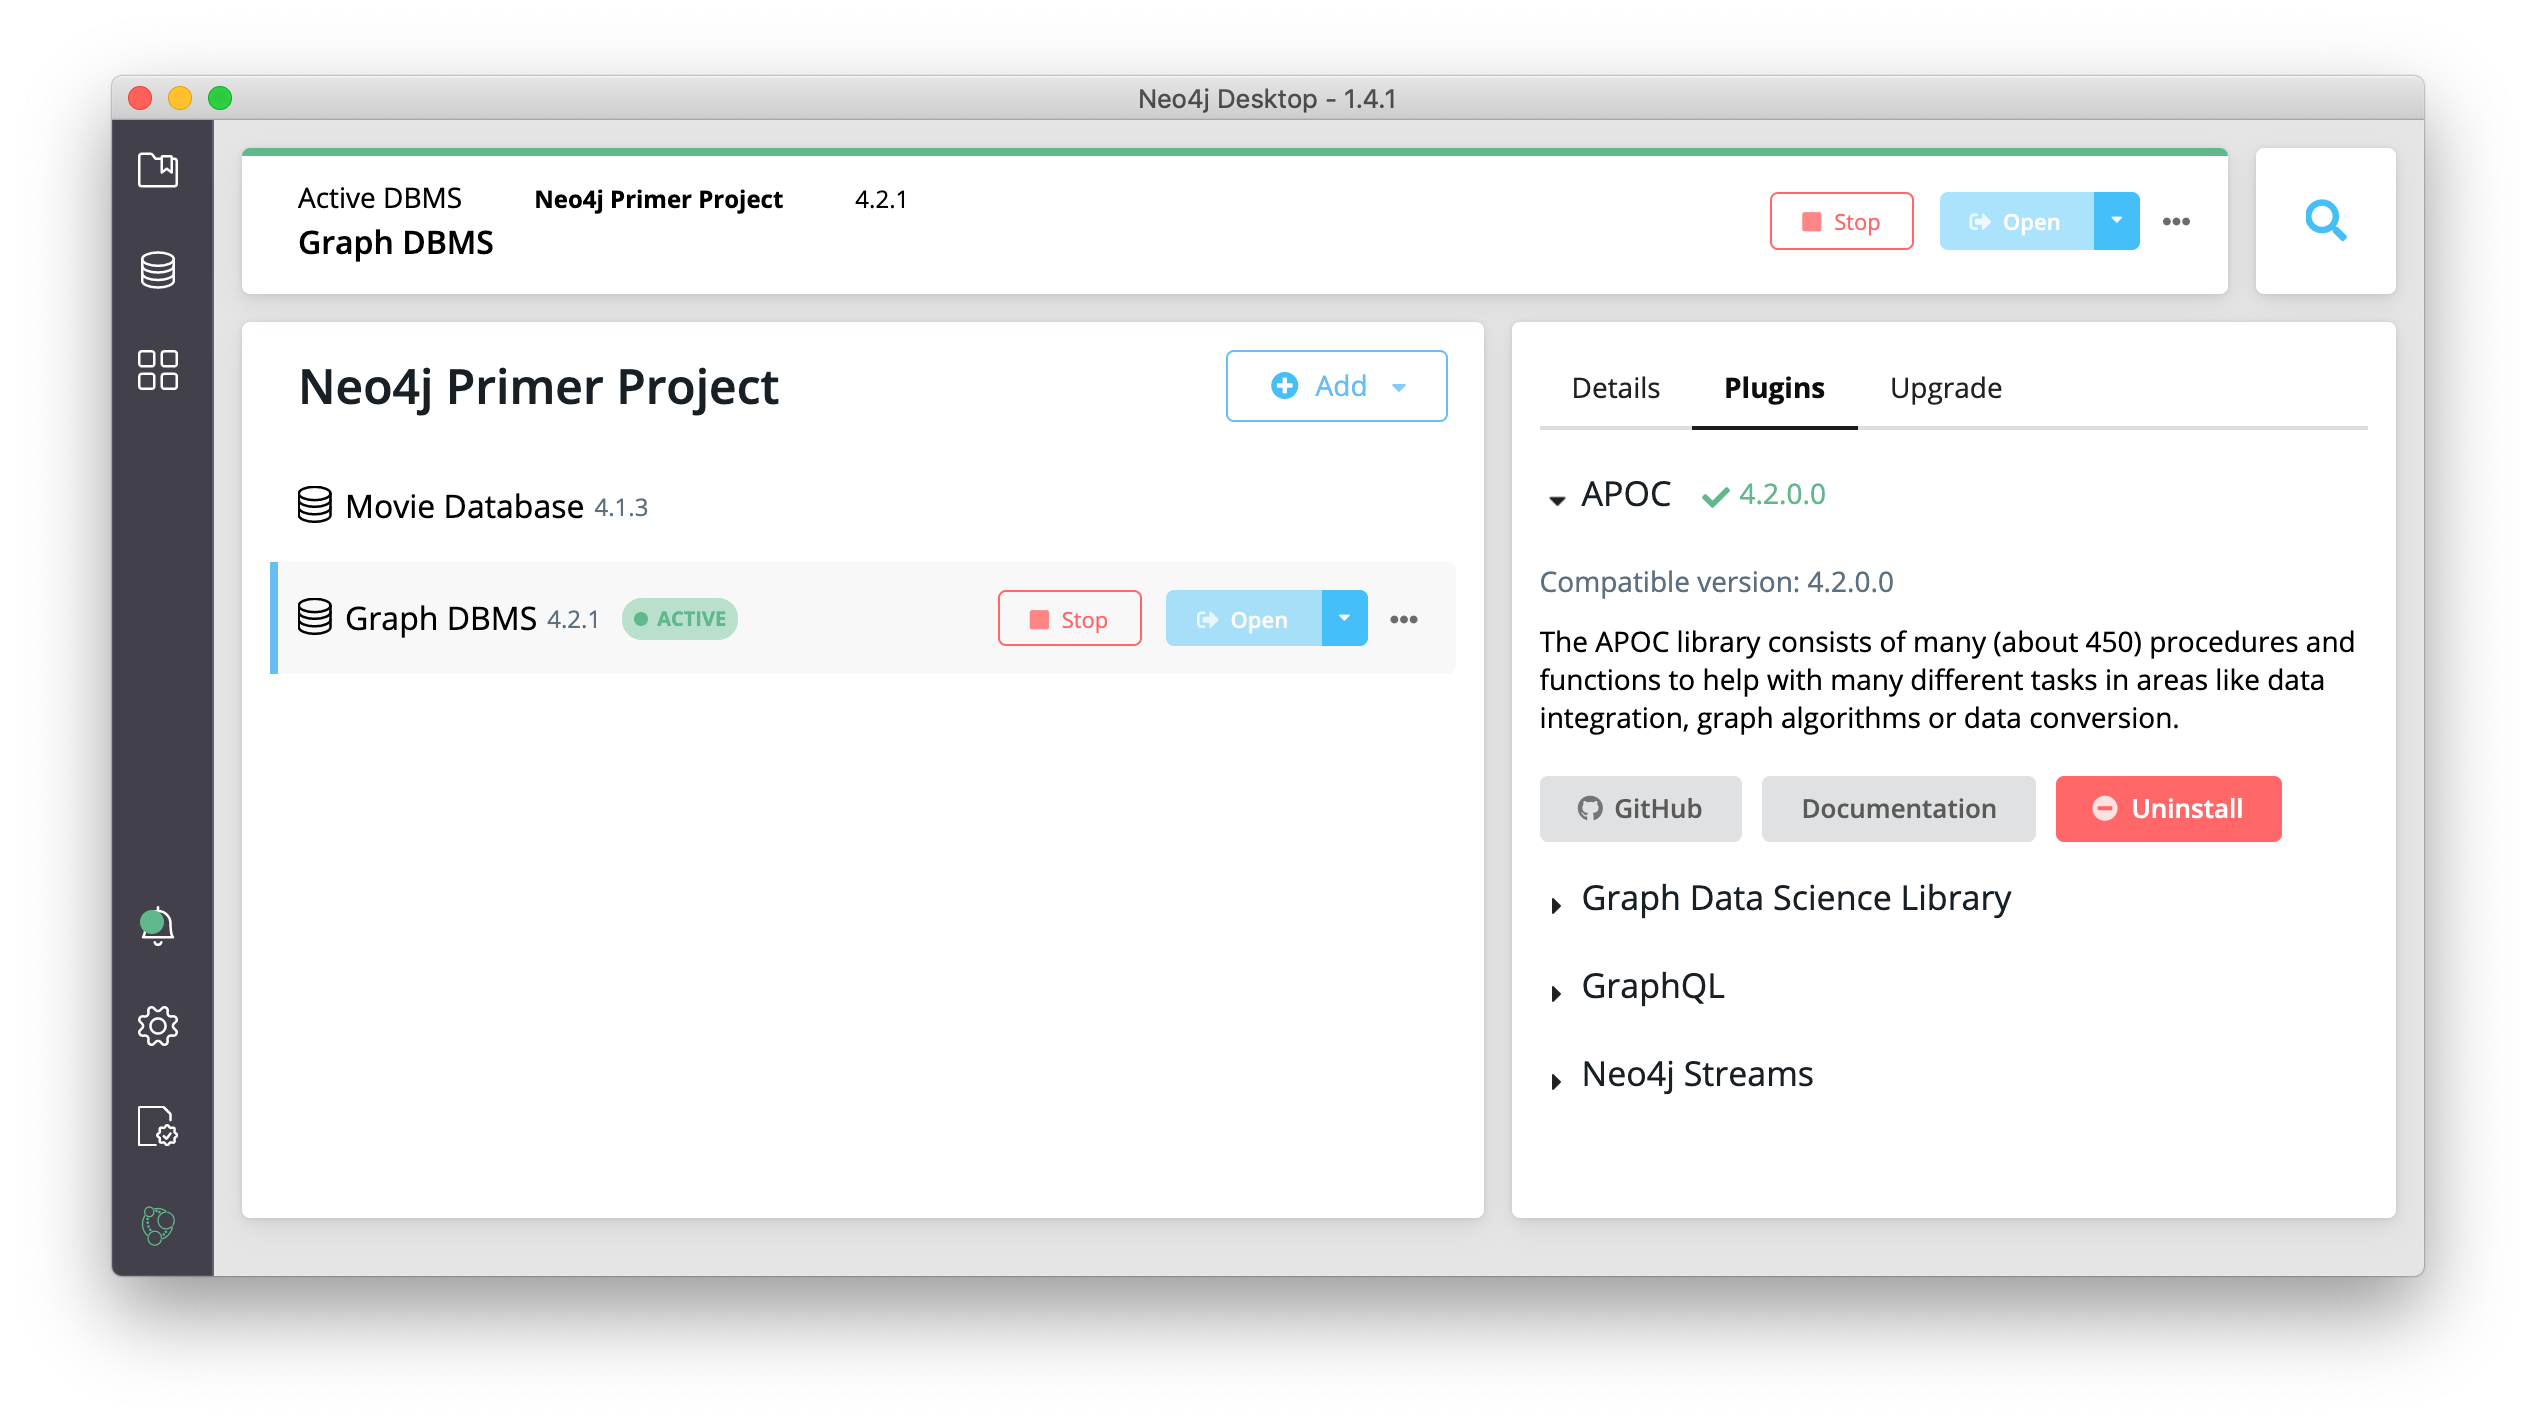

In [3]:
Image("./images/neo4j_desktop_apoc.png")

## Cypher クエリの実行

- helper 関数を定義しておく

In [4]:
def execute_cypher_query(driver: neo4j.BoltDriver, query: str) -> pd.DataFrame:
    with driver.session() as session:
        result = session.run(query)
        result = list(result)
    df = pd.DataFrame([dict(r) for r in result])
    return df

## Neo4j Desktop で作成したDBMSに接続する
- 接続情報を設定する

In [5]:
URI = "bolt://localhost:7687"
USER = "neo4j"
PASS = "password"

- `GraphDatabase` を使ってDBMSに接続する

In [6]:
driver = neo4j.GraphDatabase.driver(uri=URI, auth=(USER, PASS), encrypted=0)

## spaCy

In [7]:
nlp = spacy.load("en_core_web_sm")

- Listing 12.1 Adding the NER task to the model

In [8]:
def execute_query(query: str, params: Dict[str, str]):
    with driver.session() as session:
        result = session.run(query, **params)
        result = list(result)
    return [r['result'] for r in result]

def tokenize_and_store(text, text_id, store_tag):
    docs = nlp.pipe([text])
    for doc in docs:
        annotated_text = create_annotated_text(doc, text_id)
        spans = process_sentences(annotated_text, doc, store_tag, text_id)
        nes = process_entities(spans, text_id)

def create_annotated_text(doc, doc_id):
    query = """
    MERGE (ann:AnnotatedText {id: $id})
    RETURN id(ann) as result
    """
    params = {"id": doc_id}
    results = execute_query(query, params)
    return results[0]

def process_sentences(annotated_text, doc, store_tag: bool, text_id: int):
    """
    
    2020/01/29 現在、こちらのメソッドの動作内容を書籍中で確認することができませんでした。
    こちらの実装はコード周辺から類推して実装しているもので、必ずしも期待される動作を保証するものでは有りません。
    
    """
    spans = [s for s in doc.ents]
    sentence_id = store_sentence(doc, annotated_text, text_id, 1, store_tag)
    
    return spans

def store_sentence(sentence, annotated_text, text_id, sentence_id, store_tag):
    sentence_query = """
    MATCH (ann:AnnotatedText) WHERE id(ann) = $ann_id
    MERGE (sentence:Sentence {id: $sentence_unique_id})
    SET sentence.text = $text
    MERGE (ann)-[:CONTAINS_SENTENCE]->(sentence)
    RETURN id(sentence) as result
    """
 
    tag_occurrence_query = """
    MATCH (sentence:Sentence) WHERE id(sentence) = $sentence_id
    WITH sentence, $tag_occurrences as tags
    FOREACH ( idx IN range(0,size(tags)-2) |
    MERGE (tagOccurrence1:TagOccurrence {id: tags[idx].id})
    SET tagOccurrence1 = tags[idx]
    MERGE (sentence)-[:HAS_TOKEN]->(tagOccurrence1)
    MERGE (tagOccurrence2:TagOccurrence {id: tags[idx + 1].id})
    SET tagOccurrence2 = tags[idx + 1]
    MERGE (sentence)-[:HAS_TOKEN]->(tagOccurrence2)
    MERGE (tagOccurrence1)-[r:HAS_NEXT {sentence: sentence.id}]->(tagOccurrence2))
    RETURN id(sentence) as result
    """
 
    tag_occurrence_with_tag_query = """
    MATCH (sentence:Sentence) WHERE id(sentence) = $sentence_id
    WITH sentence, $tag_occurrences as tags
    FOREACH ( idx IN range(0,size(tags)-2) |
    MERGE (tagOccurrence1:TagOccurrence {id: tags[idx].id})
    SET tagOccurrence1 = tags[idx]
    MERGE (sentence)-[:HAS_TOKEN]->(tagOccurrence1)
    MERGE (tagOccurrence2:TagOccurrence {id: tags[idx + 1].id})
    SET tagOccurrence2 = tags[idx + 1]
    MERGE (sentence)-[:HAS_TOKEN]->(tagOccurrence2)
    MERGE (tagOccurrence1)-[r:HAS_NEXT {sentence: sentence.id}]->(tagOccurrence2))
    FOREACH (tagItem in [tag_occurrence IN $tag_occurrences WHERE tag_occurrence.is_stop = False] |
    MERGE (tag:Tag {id: tagItem.lemma}) MERGE (tagOccurrence:TagOccurrence {id: tagItem.id}) MERGE (tag)<-[:REFERS_TO]-(tagOccurrence))
    RETURN id(sentence) as result
    """  
    
    params = {
        "ann_id": annotated_text, 
        "text": sentence.text, 
        "sentence_unique_id": str(text_id) + "_" + str(sentence_id)
    }
    results = execute_query(sentence_query, params)
    
    node_sentence_id = results[0]
    tag_occurrences = []
    tag_occurrence_dependencies = []
    for token in sentence:
        lexeme = nlp.vocab[token.text]
        if not lexeme.is_punct and not lexeme.is_space:
            tag_occurrence_id = str(text_id) + "_" + str(sentence_id) + "_" + str(token.idx)
            tag_occurrence = {
                "id": tag_occurrence_id,
                "index": token.idx,
                "text": token.text,
                "lemma": token.lemma_,
                "pos": token.tag_,
                "is_stop": (lexeme.is_stop or lexeme.is_punct or lexeme.is_space)
            }

            tag_occurrences.append(tag_occurrence)
            tag_occurrence_dependency_source = str(text_id) + "_" + str(sentence_id) + "_" + str(token.head.idx)
            
            dependency = {
                "source": tag_occurrence_dependency_source, 
                "destination": tag_occurrence_id, 
                "type": token.dep_
            }

            tag_occurrence_dependencies.append(dependency)
            
    params = {
        "sentence_id": node_sentence_id, 
        "tag_occurrences":tag_occurrences
    }
    if store_tag:
        results = execute_query(tag_occurrence_with_tag_query, params)
    else:
        results = execute_query(tag_occurrence_query, params)
 
    process_dependencies(tag_occurrence_dependencies)
    return results[0]
 
def process_dependencies(tag_occurrence_dependencies):
    tag_occurrence_query = """
    UNWIND $dependencies as dependency
    MATCH (source:TagOccurrence {id: dependency.source})
    MATCH (destination:TagOccurrence {id: dependency.destination})
    MERGE (source)-[:IS_DEPENDENT {type: dependency.type}]->(destination)
    """
    execute_query(tag_occurrence_query, {"dependencies": tag_occurrence_dependencies})

    
def process_entities(spans, text_id):
    nes = []
    for entity in spans: 
        ne = {
            'value': entity.text, 
            'type': entity.label_, 
            'start_index': entity.start_char,
              'end_index': entity.end_char
        }
        nes.append(ne)
    store_entities(text_id, nes)
    return nes

def store_entities(document_id, nes):
    ne_query = """
    UNWIND $nes as item
    MERGE (ne:NamedEntity {id: toString($documentId) + "_" + toString(item.start_index)})
    SET ne.type = item.type, ne.value = item.value, ne.index = item.start_index
    WITH ne, item as neIndex
    MATCH (text:AnnotatedText)-[:CONTAINS_SENTENCE]->(sentence:Sentence)-[:HAS_TOKEN]->(tagOccurrence:TagOccurrence)
    WHERE text.id = $documentId AND tagOccurrence.index >= neIndex.start_index AND tagOccurrence.index < neIndex.end_index
    MERGE (ne)<-[:PARTICIPATES_IN]-(tagOccurrence)
    """
    execute_query(ne_query, {"documentId": document_id, "nes": nes})

- Listing 12.2 Extracting coreferences

In [9]:
nlp = spacy.load("en_core_web_sm")
coref = neuralcoref.NeuralCoref(nlp.vocab)
nlp.add_pipe(coref, name="neuralcoref")


# create_constraints() この関数の定義が書籍からは読み取れませんでした

def tokenize_and_store(text, text_id, store_tag):
    docs = nlp.pipe([text])
    for doc in docs:
        annotated_text = create_annotated_text(doc, text_id)
        spans = process_sentences(annotated_text, doc, store_tag, text_id)
        nes = process_entities(spans, text_id)
        coref = process_coreference(doc, text_id)
        
def process_coreference(doc, text_id): 
    coref = []
    if doc._.has_coref:
        for cluster in doc._.coref_clusters:
            mention = {
                'from_index': cluster.mentions[-1].start_char, 
                'to_index': cluster.mentions[0].start_char
            }
            coref.append(mention)
        store_coref(text_id, coref)
    return coref

def store_coref(document_id, corefs):
    coref_query = """
    MATCH (document:AnnotatedText)
    WHERE document.id = $documentId 
    WITH document
    UNWIND $corefs as coref  
    MATCH (document)-[*3..3]->(start:NamedEntity), (document)-[*3..3]->(end:NamedEntity) 
    WHERE start.index = coref.from_index AND end.index = coref.to_index
    MERGE (start)-[:MENTIONS]->(end)
    """
    execute_query(coref_query, {"documentId": document_id, "corefs": corefs})

- Listing 12.3 Creating the inferred knowledge graph

In [10]:
def build_inferred_graph(document_id):
    extract_direct_entities_query = """
    MATCH (document:AnnotatedText)
    WHERE document.id = $documentId
    WITH document
    MATCH (document)-[*3..3]->(ne:NamedEntity)
    WHERE NOT ne.type IN ['NP', 'NUMBER', 'DATE']
    WITH ne
    MERGE (entity:Entity {type: ne.type, id:ne.value})
    MERGE (ne)-[:REFERS_TO {type: "evoke"}]->(entity)
    """
    
    extract_indirect_entities_query = """
    MATCH (document:AnnotatedText)
    WHERE document.id = $documentId
    WITH document
    MATCH (document)-[*3..3]->(ne:NamedEntity)<-[:MENTIONS]-(mention)
    WHERE NOT ne.type IN ['NP', 'NUMBER', 'DATE']
    WITH ne, mention
    MERGE (entity:Entity {type: ne.type, id:ne.value})
    MERGE (mention)-[:REFERS_TO {type: "access"}]->(entity)
    """
    execute_query(extract_direct_entities_query, {"documentId": document_id})
    execute_query(extract_indirect_entities_query, {"documentId": document_id})

- Listing 12.4 Visualizing dependencies

In [11]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp(u"Marie Curie received the Nobel Prize in Physics")

options = {"collapse_phrases": True}

# これだとサーバが起動してしまうので、以下のように render のみ実行する
# spacy.displacy.serve(doc, style='dep', options=options)

spacy.displacy.render(doc, style='dep', options=options)

- Query 12.1 Search for subgraphs respecting the pattern we are looking for

In [12]:
tokenize_and_store("Marie Curie received the Nobel Prize in Physics in 1903.", text_id=1, store_tag=True)

query = """
MATCH (verb:TagOccurrence {pos: "VBD", lemma:"receive"})
WITH verb
MATCH p=(verb)-[:IS_DEPENDENT {type:"nsubj"}]->(subject)-[:PARTICIPATE_IN]->(person:NamedEntity {type: "PERSON"})
MATCH q=(verb)-[:IS_DEPENDENT {type:"dobj"}]->(object)-[:PARTICIPATE_IN]->(woa:NamedEntity {type: "WORK_OF_ART"})
RETURN verb, person, woa, p, q
"""
df = execute_cypher_query(driver, query)
df.head()

""


- Listing 12.5 Extracting relationships from typed dependencies

In [13]:
def tokenize_and_store(text, text_id, store_tag):
    docs = nlp.pipe([text])
    
    for doc in docs:
        annotated_text = create_annotated_text(doc, text_id)
        spans = process_sentences(annotated_text, doc, store_tag, text_id)
        nes = process_entities(spans, text_id)
        coref = process_coreference(doc, text_id)
        build_inferred_graph(text_id)
        
        rules = [
            {
                'type': 'RECEIVE_PRICE',
                'verbs': ['receive'],
                'subjectTypes': ['PERSON', 'NP'],
                'objectTypes': ['WORK_OF_ART']
            }
        ]
        extract_relationships(text_id, rules)
        
def extract_relationships(document_id, rules):
    extract_relationships_query = """
    MATCH (document:AnnotatedText)
    WHERE document.id = $documentId
    WITH document
    UNWIND $rules as rule
    MATCH (document)-[*2..2]->(verb:TagOccurrence {pos: "VBD"})
    MATCH (verb:TagOccurrence {pos: "VBD"})
    WHERE verb.lemma IN rule.verbs
    WITH verb, rule
    MATCH (verb)-[:IS_DEPENDENT {type:"nsubj"}]->(subject)-[:PARTICIPATE_IN]->(subjectNe:NamedEntity)
    WHERE subjectNe.type IN rule.subjectTypes
    MATCH (verb)-[:IS_DEPENDENT {type:"dobj"}]->(object)-[:PARTICIPATE_IN]->(objectNe:NamedEntity {type: "WORK_OF_ART"})
    WHERE objectNe.type IN rule.objectTypes
    WITH verb, subjectNe, objectNe, rule
    MERGE (subjectNe)-[:IS_RELATED_TO {root: verb.lemma, type: rule.type}]->(objectNe)
    """
    execute_query(extract_relationships_query, {"documentId": document_id, "rules":rules})

- Listing 12.6 Extracting relationships and storing them in the inferred knowledge graph

In [14]:
def build_relationships_inferred_graph(document_id):
    extract_relationships_query = """
    MATCH (document:AnnotatedText)
    WHERE document.id = $documentId
    WITH document
    MATCH (document)-[*3..3]->(ne1:NamedEntity)
    MATCH (entity1:Entity)<-[:REFERS_TO]-(ne1:NamedEntity)-[r:IS_RELATED_TO]->(ne2:NamedEntity)-[:REFERS_TO]->(entity2:Entity)
    MERGE (evidence:Evidence {id: id(r), type:r.type})
    MERGE (rel:Relationship {id: id(r), type:r.type})
    MERGE (ne1)<-[:SOURCE]-(evidence)
    MERGE (ne2)<-[:DESTINATION]-(evidence)
    MERGE (rel)-[:HAS_EVIDENCE]->(evidence)
    MERGE (entity1)<-[:FROM]-(rel)
    MERGE (entity2)<-[:TO]-(rel)
    """
    execute_query(extract_relationships_query, {"documentId": document_id})

- Getting the winners of the Nobel Prize in Chemistry

In [15]:
query = """
MATCH (nodelPrize:Entity {type:"Prize"})-[:TO]->(rel:Relationship {type: "RECEIVE_PRIZE"})-[:FROM]->(winner:Entity {type: "Person"})
WHERE nodelPrize.id CONTAINS "the Nobel Prize in Chemistry"
RETURN winner
"""
df = execute_cypher_query(driver, query)
df.head()

""


- Accessing ConceptNet from Python

In [16]:
import requests
obj = requests.get('http://api.conceptnet.io/c/en/marie_curie').json()
print(obj['edges'][0]['rel']['label'] + ": " + obj['edges'][0]['end']['label'])

Synonym: Marya Sklodowska


- Listing 12.9 TextRank applied

In [17]:
def tokenize_and_store(text, text_id, store_tag):
    docs = nlp.pipe([text])
    for doc in docs:
        annotated_text = create_annotated_text(doc, text_id)
        spans = process_sentences(annotated_text, doc, store_tag, text_id)
        
        process_entities(spans, text_id)
        process_coreference(doc, text_id)
        process_textrank(doc, text_id)
        
def process_textrank(doc, text_id):
    keywords = []
    spans = []
    for p in doc._.phrases:
        for span in p.chunks:
            item = {"span": span, "rank": p.rank}
            spans.append(item)
    spans = filter_extended_spans(spans)
    for item in spans:
        span = item['span']
        keyword = {"id": span.text, "start_index": span.start_char, "end_index": span.end_char}
        if len(span.ents) > 0:
            keyword['NE'] = span.ents[0].label_
        keyword['rank'] = item['rank']
        keywords.append(keyword)
    store_keywords(text_id, keywords)

def store_keywords(document_id, keywords):
    ne_query = """
    UNWIND {keywords} as keyword
    MERGE (kw:Keyword {id: keyword.id})
    SET kw.NE = keyword.NE, kw.index = keyword.start_index, kw.endIndex = keyword.end_index
    WITH kw, keyword
    MATCH (text:AnnotatedText)
    WHERE text.id = {documentId}
    MERGE (text)<-[:DESCRIBES {rank: keyword.rank}]-(kw)
    """
    execute_query(ne_query, {"documentId": document_id, "keywords": keywords})

- Get the list of top 100 most frequent keywords

In [18]:
query = """
MATCH (n:Keyword)-[:DESCRIBES]->(text:AnnotatedText) 
RETURN n.id as keywords, count(n) as occurrences 
order by occurrences desc
limit 100
"""
df = execute_cypher_query(driver, query)
df.head()

""


- Creating the co-occurrence graph

In [19]:
query = """
CALL apoc.periodic.submit('CreateCoOccurrence', 
'CALL apoc.periodic.iterate("MATCH (k:Keyword)-[:DESCRIBES]->(text:AnnotatedText)
WITH k, count(DISTINCT text) AS keyWeight
WHERE keyWeight > 5
RETURN k, keyWeight", 
"MATCH (k)-[:DESCRIBES]->(text)<-[:DESCRIBES]-(k2:Keyword)
WHERE k <> k2
WITH k, k2, count(DISTINCT text) AS weight, keyWeight
WHERE weight > 10
WITH k, k2, k.value as kValue, k2.value as k2Value, weight, (1.0f*weight)/keyWeight  as normalizedWeight
CREATE (k)-[:CO_OCCURR {weight: weight, normalizedWeight: normalizedWeight}]->(k2)", {batchSize:100, iterateList:true, parallel:false})')
"""
df = execute_cypher_query(driver, query)
df.head()

,name,delay,rate,done,cancelled
0,CreateCoOccurrence,0,0,False,False


- Creating a “virtual graph” in the knowledge graph

In [ ]:
query = """
CALL gds.graph.create(
    'keywordsGraph',
    'Keyword',
    {
        CO_OCCURR: {
            orientation: 'NATURAL'
        }
    },
    {
        relationshipProperties: 'normalizedWeight'
    }
)
"""
df = execute_cypher_query(driver, query)
df.head()

- Revealing communities using Louvain

In [ ]:
query = """
CALL gds.louvain.write('keywordsGraph', {
    relationshipWeightProperty: 'normalizedWeight',
    writeProperty: 'community'
}) YIELD nodePropertiesWritten,  communityCount, modularity
RETURN nodePropertiesWritten,  communityCount, modularity
"""
df = execute_cypher_query(driver, query)
df.head()

- Getting the communities and the top 25 keywords for each community

In [ ]:
query = """
MATCH (k:Keyword)-[:DESCRIBES]->(text:AnnotatedText)
WITH k, count(text) as weight
WHERE weight > 5
with k.community as community, k.id as keyword, weight
order by community, weight desc
WITH community, collect(keyword) as communityMembers
order by size(communityMembers) desc
RETURN community as communityId, communityMembers[0..25] as topMembers, size(communityMembers) as size
"""
df = execute_cypher_query(driver, query)
df.head()